In [43]:
import pandas as pd
import numpy as np
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping


In [3]:
df=pd.read_csv(r'/content/DailyDelhiClimateTrain.csv')

In [4]:
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


# Data Preprocessing and Visualization


In [12]:
temp = go.Scatter(x=df.index, y=df['meantemp'], mode='lines', name='Temperature')

# Layout settings
layout = go.Layout(
    title='Mean Temperature',
    xaxis_title='date',
    yaxis_title='meantemp',
    legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    height=500,
    width=1100,
)

# Combine the traces and layout
fig = go.Figure(data=temp, layout=layout)

# Display the plot
pio.show(fig)

In [7]:
humidity=go.Scatter(x=df.index,y=df['humidity'], mode='lines', name='Humidity',line=dict(color='red'))

layout=go.Layout(
    title='Humidity Over Line',
    xaxis_title='Date',
    yaxis_title='Humidity',
   legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    width=1100,
    height=500
)

fig=go.Figure(data=[humidity],layout=layout)
pio.show(fig)

In [8]:
wind_speed=go.Scatter(x=df.index,y=df['wind_speed'],mode='lines',name='wind_speed',line=dict(color='purple'))

layout=go.Layout(title='Wind Speed Over Line',
    xaxis_title='Date',
    yaxis_title='Wind Speed',
   legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    width=1100,
    height=500)

fig=go.Figure(data=[wind_speed],layout=layout)
pio.show(fig)


In [9]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [10]:
pressure=go.Scatter(x=df.index,y=df['meanpressure'],mode='lines',name='pressure',line=dict(color='green'))

layout=go.Layout(title='Mean Temprature Over Line',
    xaxis_title='date',
    yaxis_title='Mean Temprature',
   legend=dict(x=0, y=1.0),
    margin=dict(l=80, r=80, t=40, b=40),
    width=1100,
    height=500)

fig=go.Figure(data=[pressure],layout=layout)
pio.show(fig)

In [13]:
dataset=df['meantemp']
df2=pd.DataFrame(dataset)
df2

,meantemp
0,10.000000
1,7.400000
2,7.166667
3,8.666667
4,6.000000
...,...
1457,17.217391
1458,15.238095
1459,14.095238
1460,15.052632


In [14]:
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))  # reshape(-1, 1) converts it to a 2D array of shape (rows, 1), which is required by fit_transform().

In [15]:
train_size=int(len(df2)*0.80)
test_size=len(df2)-train_size


In [16]:
print(train_size,'/',test_size)

1169 / 293


In [18]:
train_data = df2[:train_size, 0:1] #0:1 means "select column index 0" but keep the result as a 2D array (not flattened). That’s why it uses 0:1 instead of just 0.
train_data.shape
#Keeping the column index as 0:1 (instead of just 0) ensures the result remains a 2D array, which is important for compatibility with models like LSTMs or CNNs that expect 2D or 3D input.

(1169, 1)

In [22]:
x_train=[]
y_train=[]
# This code takes the last 60 values from the training data to create input (x) and the next value as output (y), so the model can learn patterns and predict the next number based on the previous 60.

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

x_train = np.array(x_train)
y_train = np.array(y_train)


In [23]:
 # Reshaping the input to 3D array [samples, time_steps, features].

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [27]:
model=Sequential([
    LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)),
    LSTM(64,return_sequences=False),
    Dense(32), #32 neurons to detect patterns
    Dense(16),
    Dense(1)# added 1 neuron for final output
])
#This code builds an LSTM model that looks at the last 60 time steps and learns to predict the next value. It uses two LSTM layers to understand sequence patterns and Dense layers to make the final prediction. The model is compiled with a loss and metric suitable for time-series regression tasks.
model.compile(loss='mse',optimizer='adamax',metrics=['mean_absolute_error'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
Early_Stopping=EarlyStopping(monitor='loss',patience=15,restore_best_weights=True)
history=model.fit(x_train,y_train,epochs=100,batch_size=32,callbacks=Early_Stopping)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0078 - mean_absolute_error: 0.0707
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0072 - mean_absolute_error: 0.0679
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0061 - mean_absolute_error: 0.0629
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0058 - mean_absolute_error: 0.0607
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0059 - mean_absolute_error: 0.0609
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0057 - mean_absolute_error: 0.0611
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0052 - mean_absolute_error: 0.0565
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0051 - mean_absolute_error: 0.0564
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0053 - mean_absolute_error: 0.0575
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0050 - mean_absolute_error: 0.0563
Epoch 11/100
35/35 ━━━━━━━━━━

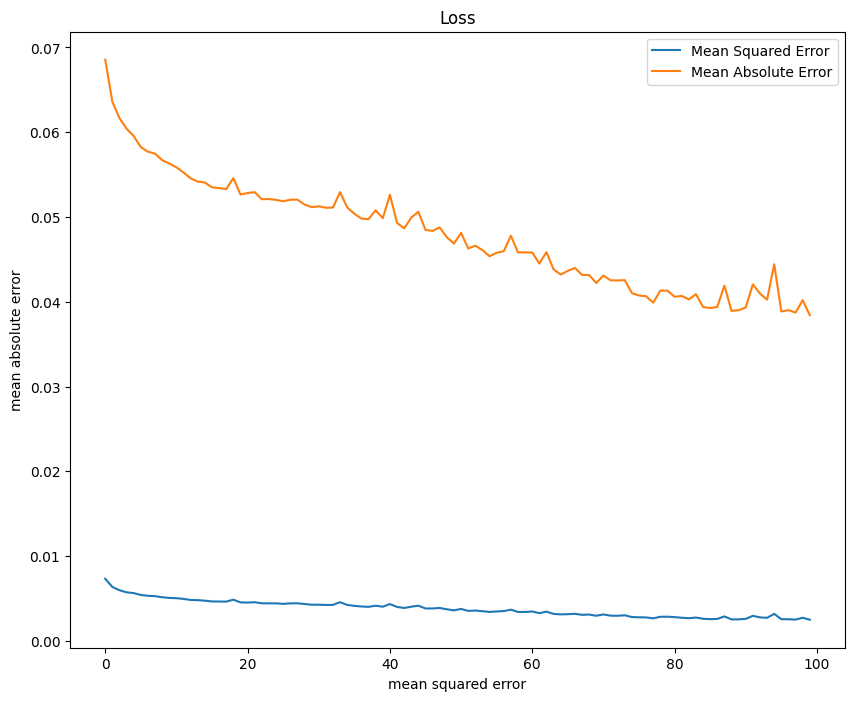

In [32]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Loss')
plt.ylabel('mean absolute error')
plt.xlabel('mean squared error')
plt.legend(['Mean Squared Error','Mean Absolute Error'])

In [33]:
test_data = df2[train_size - 60:, :]
x_test=[]
y_test=[]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])
  y_test.append(test_data[i,0])

x_train=np.array(x_test)
y_train=np.array(y_test)

In [34]:
x_test, y_test = np.array(x_test), np.array(y_test) # converted into array as lstm model accpets only array data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [35]:
x_test.shape

(293, 60, 1)

In [36]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)
predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


array([[23.72194 ],
       [24.307112],
       [24.44199 ],
       [25.901442],
       [26.296509],
       [26.760143],
       [27.083227],
       [26.844366],
       [25.801085],
       [26.18681 ],
       [27.50046 ],
       [28.991   ],
       [26.131832],
       [26.353868],
       [26.199888],
       [26.935972],
       [28.709023],
       [29.466763],
       [30.033226],
       [31.304417],
       [32.257957],
       [32.14338 ],
       [31.805199],
       [31.135117],
       [30.081553],
       [29.482662],
       [30.39537 ],
       [31.66046 ],
       [30.31409 ],
       [30.383589],
       [31.450073],
       [32.62137 ],
       [33.210644],
       [34.778255],
       [34.31417 ],
       [34.250687],
       [33.80664 ],
       [33.818993],
       [33.80424 ],
       [33.309464],
       [32.338303],
       [31.807884],
       [32.05561 ],
       [33.302647],
       [33.270763],
       [34.027603],
       [34.05265 ],
       [33.330845],
       [34.40334 ],
       [36.924683],


In [37]:
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(0.1)

In [38]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,23.721939,24.066667
1,24.307112,23.937500
2,24.441990,26.312500
3,25.901442,26.187500
4,26.296509,26.785714
...,...,...
288,16.503782,17.217391
289,16.824757,15.238095
290,15.940681,14.095238
291,14.939378,15.052632


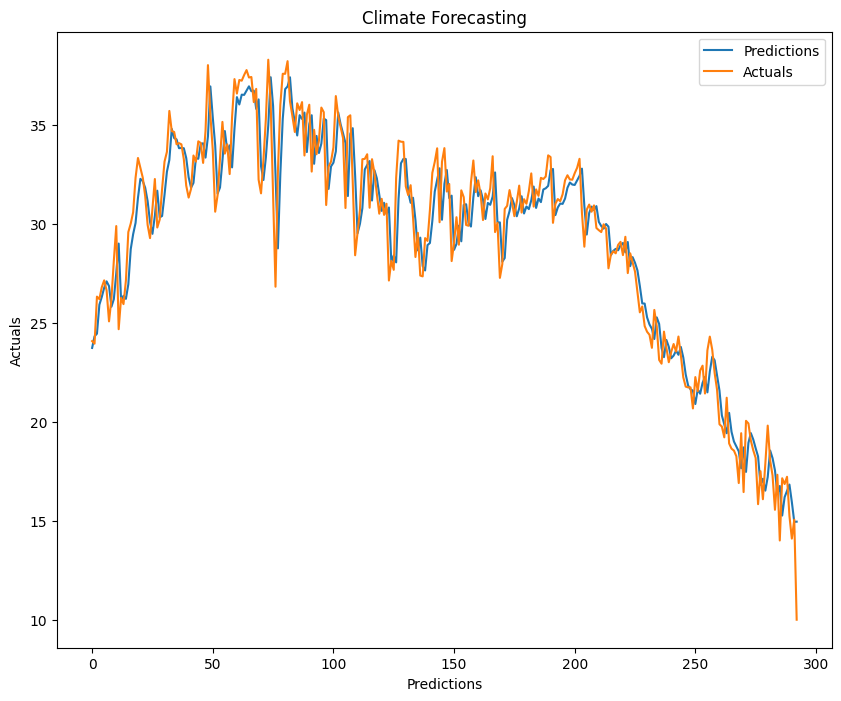

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(preds_acts["Predictions"])
plt.plot(preds_acts["Actuals"])
plt.title("Climate Forecasting")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.legend(["Predictions", "Actuals"])
plt.show()

In [49]:
# Define the insert_end function
def insert_end(Xin, new_input):
    timestep = Xin.shape[1]  # Ensure timestep matches the input shape
    Xin[:, :-1, :] = Xin[:, 1:, :]  # Shift sequence
    Xin[:, -1, :] = new_input  # Insert new input at the end
    return Xin

# Fix: Use the last real date from the Date column (not the index)
last_known_date = pd.to_datetime(df['date'].iloc[-1])  # <- Update this to your actual date column

# Forecast future values
future = 50
forcast = []
Xin = x_test[-1:, :, :]
time = []

for i in range(future):
    out = model.predict(Xin, batch_size=5, verbose=0)
    forcast.append(out[0])
    Xin = insert_end(Xin, out[0].reshape(1, 1, 1))
    time.append(last_known_date + timedelta(days=i + 1))  # Start from the next day

# Reshape and inverse scale
forcasted_output = np.array(forcast).reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)

# Create DataFrame
forcasted_output_df = pd.DataFrame(forcasted_output, columns=['meantemp'])
date_df = pd.DataFrame(time, columns=['Date'])
df_result = pd.concat([date_df, forcasted_output_df], axis=1)

# Display
print(df_result.head())

        Date   meantemp
0 2017-01-02  21.144287
1 2017-01-03  21.233326
2 2017-01-04  21.321077
3 2017-01-05  21.407515
4 2017-01-06  21.492615


In [50]:
df_result.head(50)

,Date,meantemp
0,2017-01-02,21.144287
1,2017-01-03,21.233326
2,2017-01-04,21.321077
3,2017-01-05,21.407515
4,2017-01-06,21.492615
5,2017-01-07,21.576365
6,2017-01-08,21.658735
7,2017-01-09,21.739706
8,2017-01-10,21.819263
9,2017-01-11,21.897385
